Basic imports beforehand

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's grab our cleaned data and put it in a pandas DataFrame. Let's remove the games that were terminated early because one of the players was cheating, as these games aren't fair and shouldn't be considered in our analysis.

In [2]:
data = pd.read_pickle('./Chess_Data.pickle')
data.drop(data.loc[data['Termination'] == 'Rules infraction'].index, inplace=True)

Let's begin by visualizing how many games are won by white, how many games are won by black, and how many games are draws.

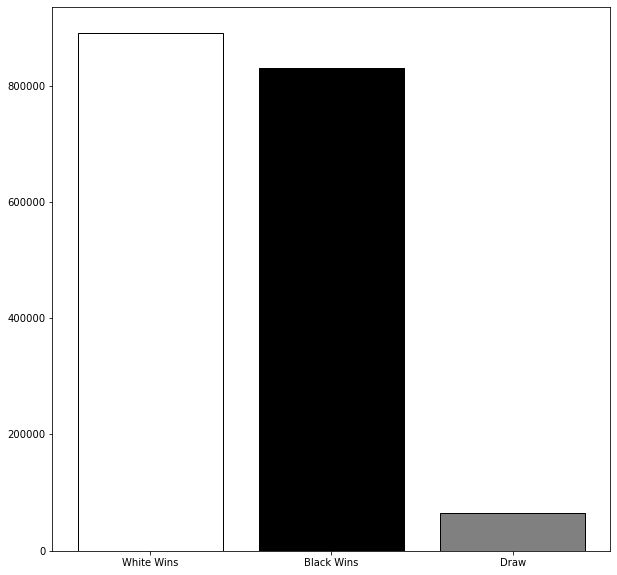

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar('White Won', len(data.loc[data['Result'] == '1-0']), color='white', edgecolor='black')
ax.bar('Black Won', len(data.loc[data['Result'] == '0-1']), color='black', edgecolor='black')
ax.bar('Draw', len(data.loc[data['Result'] == '1/2-1/2']), color='gray', edgecolor='black');

That gives us an idea of the overall chances of white winning versus black winning, but lets break it down a bit and see if there is a difference between each type of game (note the difference in y-axis scales, this is because we have different numbers of each game).

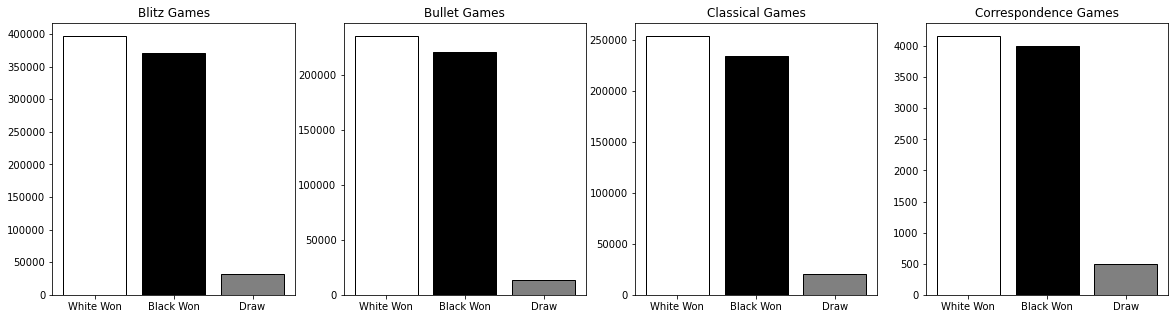

In [20]:
labels = np.unique(data['Game Type'])
whiteWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1-0')])
blackWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '0-1')])
draw0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1/2-1/2')])
whiteWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1-0')])
blackWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '0-1')])
draw1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1/2-1/2')])
whiteWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1-0')])
blackWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '0-1')])
draw2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1/2-1/2')])
whiteWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1-0')])
blackWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '0-1')])
draw3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1/2-1/2')])

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].bar('White Won', whiteWon0, color='white', edgecolor='black')
axs[0].bar('Black Won', blackWon0, color='black', edgecolor='black')
axs[0].bar('Draw', draw0, color='gray', edgecolor='black')
axs[0].set_title(f'{labels[0]} Games')
axs[1].bar('White Won', whiteWon1, color='white', edgecolor='black')
axs[1].bar('Black Won', blackWon1, color='black', edgecolor='black')
axs[1].bar('Draw', draw1, color='gray', edgecolor='black')
axs[1].set_title(f'{labels[1]} Games')
axs[2].bar('White Won', whiteWon2, color='white', edgecolor='black')
axs[2].bar('Black Won', blackWon2, color='black', edgecolor='black')
axs[2].bar('Draw', draw2, color='gray', edgecolor='black')
axs[2].set_title(f'{labels[2]} Games')
axs[3].bar('White Won', whiteWon3, color='white', edgecolor='black')
axs[3].bar('Black Won', blackWon3, color='black', edgecolor='black')
axs[3].bar('Draw', draw3, color='gray', edgecolor='black')
axs[3].set_title(f'{labels[3]} Games');